Сетевой дискаунтер "Хлеб-Соль" внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: 1) Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; 2) Контролировать добросовестность кассиров при продаже алкоголя.

Нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Содержание  <a class="anchor" id="0-bullet">
* [1. Исследовательский анализ данных](#1-bullet)
* [2. Обучение модели](#2-bullet)
* [3. Анализ обученной модели](#3-bullet)

# 1. Исследовательский анализ данных<a class="anchor" id="1-bullet"></a>

In [16]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import display

In [17]:
# считаем файл данных
labels = pd.read_csv('/datasets/faces/labels.csv')

# выведем информацию для загруженной таблицы
print(labels.info())
display(pd.concat([labels.head(4), labels.tail(3)]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


<span style="color:purple">В таблице присутствует 7591 запись. Аналитика представлена двумя признаками - столбец file_name содержит название файла с фотографией, real_age - возраст человека. Пропусков нет.

<span style="color:purple">Построим график распределения возраста в выборке.

Text(0.5, 0, 'Возраст, лет')

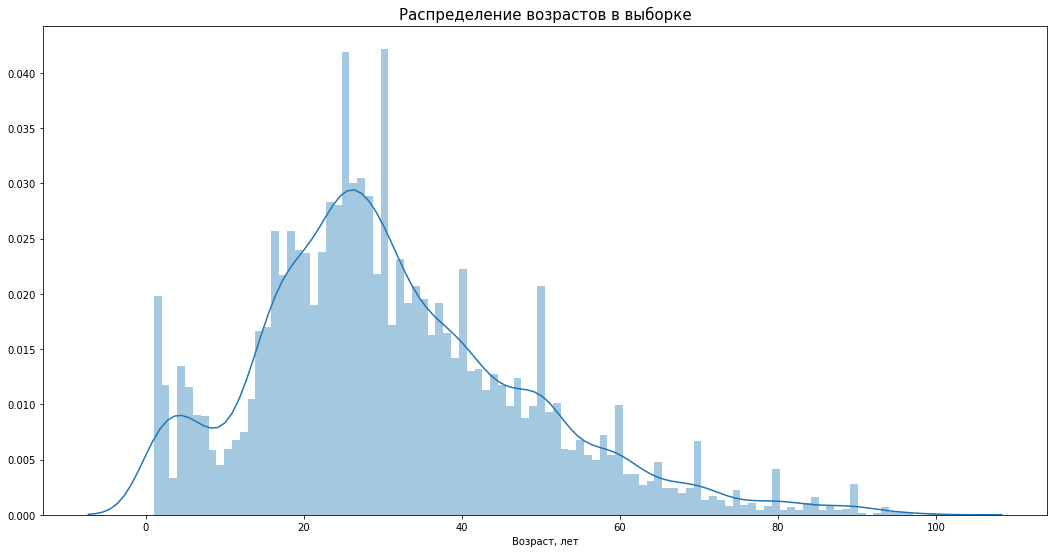

In [18]:
plt.figure(figsize=(18,9))
sns.distplot(labels['real_age'], bins=100)
plt.title('Распределение возрастов в выборке', size=15)
plt.xlabel('Возраст, лет')

In [19]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<span style="color:purple">Возраст большей части людей на изображениях - 20-30 лет, есть пиковые значения -25 и 30 лет, также выделяются "юбилейные" возраста 40, 50, 60, 70, 80, 90 лет. Медиана - 29 лет.

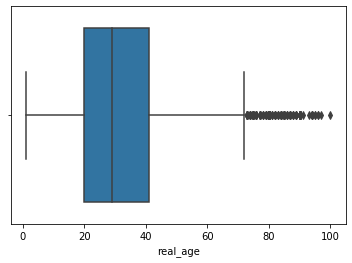

In [20]:
sns.boxplot(x="real_age", data=labels)

<span style="color:purple">В выборке есть выбросы, присутствует даже фото человека 100 лет. Никаких действий по удалению выбросов осуществлять не будем.

<span style="color:purple">Напечатаем на экране некоторое количество фотографий.

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

Found 6073 validated image filenames.


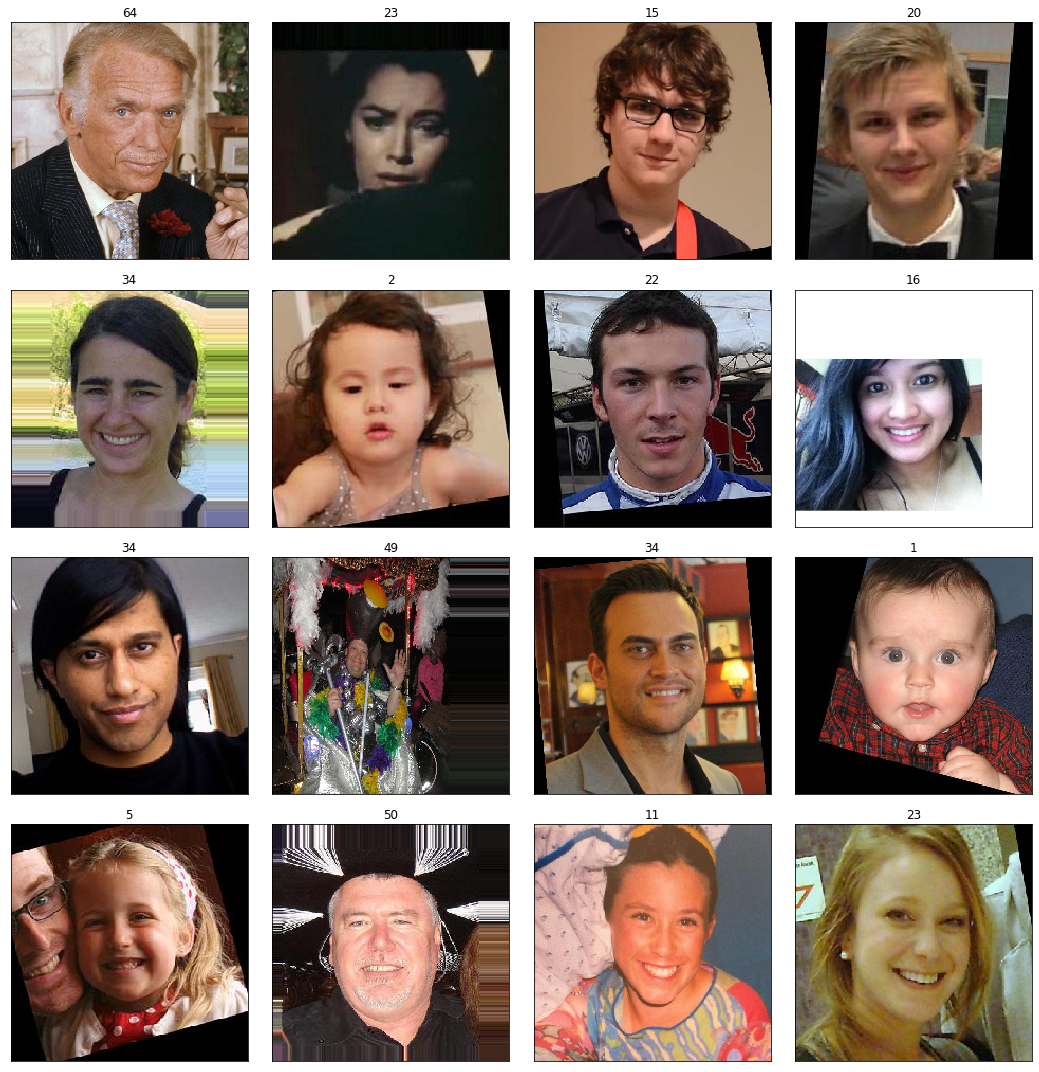

In [33]:
features, target = next(train_datagen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

# 2. Обучение модели<a class="anchor" id="2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Применим свёрточную нейронную сеть ResNet50, используем 5 эпох, обучение будем производить на MSE, контрольная метрика - МАЕ. Используем аугментацию - горизонтальный поворот. Оптимизатор - Adam, значение lr = 0.0001. В выходном слое - 1 нейрон с активацией relu. Соотношение обучающей и тестовой выборок - 4:1. На тестовой выборке нам необходимо достигнуть значения МАЕ < 8. Поехали.

<span style="color:purple">Перенесём сюда код обучения модели и её результат вывода на экран. Код в этом разделе запускается в специальном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

from tensorflow.keras.applications.resnet import ResNet50

import pandas as pd


def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                      horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):

    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

Train for 190 steps, validate for 48 steps

Epoch 1/5
2020-11-27 09:12:20.082714: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2020-11-27 09:12:20.826547: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

190/190 - 108s - loss: 246.1831 - mae: 11.0608 - val_loss: 715.1520 - val_mae: 21.6577

Epoch 2/5

190/190 - 41s - loss: 77.3249 - mae: 6.6613 - val_loss: 785.3662 - val_mae: 22.9738

Epoch 3/5

190/190 - 41s - loss: 49.9092 - mae: 5.3777 - val_loss: 270.4742 - val_mae: 12.2909

Epoch 4/5

190/190 - 41s - loss: 37.0575 - mae: 4.6559 - val_loss: 90.9168 - val_mae: 7.2487

Epoch 5/5

190/190 - 41s - loss: 27.8237 - mae: 4.0413 - val_loss: 69.5025 - val_mae: 6.2233

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
  
48/48 - 8s - loss: 69.5025 - mae: 6.2233

Test MAE: 6.2233

# 3. Анализ обученной модели<a class="anchor" id="3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Достигнуто значение MAE = 6.22 на тестовой выборке, что соответствует требованиям. Однако жаль, что нельзя попробовать улучшить результат, есть ощущение, что увеличением количества эпох и некоторой иной подкруткой параметров удалось бы добиться выхода на значение, меньшее 6.